# Coastal Compound Floods

### TODO
- Check extremes
- Verify with reported floods

## Background

**Converted all to daily to match cmip6 $\rightarrow$ daily mean from hourly and original cmip6**

#### Observational data
- Mean wind Data (m/s) from noaa (6 min)
- Max Water Level (m) from noaa (6 min)
- Mean wind speed, mean direction, total precip from meteostat (1 hr)

#### CMIP6 only using ssp 245
- https://developers.google.com/earth-engine/datasets/catalog/NASA_GDDP-CMIP6
- sfcwind: LARC_sfcWind_historical_daily.csv, LARC_sfcWind_ssp245_daily.csv
- pr: LARC_pr_historical_daily.csv, LARC_pr_ssp126_daily.csv, LARC_pr_ssp245_daily.csv, LARC_pr_ssp370_daily.csv
    - The sum of liquid and frozen water, comprising rain and snow, that falls to the Earth's surface. It is the sum of large-scale precipitation and convective precipitation. This parameter does not include fog, dew or the precipitation that evaporates in the atmosphere before it lands at the surface of the Earth. This variable represents amount of water per unit area and time.

### Modifications and Assumptions
**General**
- Rows with less than n observations per year were removed
- Only 1950 and after
- Set all 0 precip to nan

**Wind**
- wind direction degree [0, 360]
- wind gust >= speed >= 0
- Extremes: max speed and gust in 1 hour (based on 6 minute intervals)
- Circular mean wind direction (max mode for text version)

**Water Level**
- mhhw: Values above zero indicate water exceeding normal high tide levels (potential flooding)
- Sigma - Standard deviation of 1 second samples used to compute the water level height; **sigma > 3** is considered bad quality and removed
- msl was removed from analysis because highly correlated with mhhw (same distribution but shifted)


<details>
<summary> NOAA Tides & Currents: mean in past time interval </summary>
    
- Virginia: https://tidesandcurrents.noaa.gov/map/index.html?region=Virginia#
- Yorktown: https://tidesandcurrents.noaa.gov/inventory.html?id=8637689
- Sewells Point: https://tidesandcurrents.noaa.gov/inventory.html?id=8638610
- Gloucester before 2003: https://tidesandcurrents.noaa.gov/inventory.html?id=8637624
- https://pypi.org/project/noaa-coops/
- product: https://api.tidesandcurrents.noaa.gov/api/prod/#products
- datum: https://api.tidesandcurrents.noaa.gov/api/prod/#datum:~:text=for%20the%20station-,Datum,-The%20datum%20can
- Output columns: https://api.tidesandcurrents.noaa.gov/api/prod/responseHelp.html
- https://maps.waterdata.usgs.gov/mapper/index.html
- dates of active stations are from (first available day) to (at most day of download)
</details>

<details>
<summary> Meteostat: measurements at end of each hour </summary>
    
- https://dev.meteostat.net/python/daily.html#data-structure
- Variables and units: https://dev.meteostat.net/formats.html
- Station data columns: https://dev.meteostat.net/python/stations.html#data-structure
</details>

<details>
<summary> 2016 Floods </summary>
    
- September 2-3, 2016 Tropical Storm Hermine https://www.weather.gov/mhx/hermine_090216
- September 11 – 23, 2016: Tropical Storm Julia https://www.wpc.ncep.noaa.gov/tropical/rain/julia2016.html
- October 8, 2016: Hurricane Matthew https://www.weather.gov/ilm/matthew
</details>

In [1]:
# !pip install noaa_coops
# !pip install meteostat

import os
import re
import glob
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.colors import qualitative
from plotly.subplots import make_subplots
import geopandas as gpd
from shapely.geometry import Point, box
import contextily as cx
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from IPython.display import Image, display
import plot_settings
from statsmodels.tsa.seasonal import STL
from scipy.signal import periodogram

warnings.filterwarnings('ignore')

static = True # interactive/static plotly plots
PATH = '../data/floods' 
PATH2 = PATH + '/daily_mean' # daily_max, daily_mean, hourly_max
# !python process_flood.py --output_dir $PATH

# Load Data

In [2]:
# Load NOAA and Meteo
noaa = pd.read_csv(f'{PATH}/noaa_tc.csv')
noaa['id'] = noaa.id.astype(str)
noaa[['start_date', 'end_date']] = noaa[['start_date', 'end_date']].apply(pd.to_datetime)
noaa['station'] = noaa.name + ' ' + noaa.id
wind_stations = noaa.loc[noaa.variable == 'Wind', 'id'].values
water_stations = noaa.loc[noaa.variable == 'Verified 6-Minute Water Level', 'id'].values

meteo = pd.read_csv(f'{PATH}/meteo.csv')
meteo[['hourly_start', 'hourly_end']] = meteo[['hourly_start', 'hourly_end']].apply(pd.to_datetime)
meteo['station'] = meteo.name + ' ' + meteo.id

# Load DataFrames
wind_df = pd.read_parquet(f'{PATH2}/noaa_tc.wind.parquet')
wind_df = wind_df.loc[:, ~wind_df.columns.str.contains('flag')]
water_df = pd.read_parquet(f'{PATH2}/noaa_tc.water.parquet')
meteo_df = pd.read_parquet(f'{PATH2}/meteo.pr_wind.parquet')
cmip_df = pd.read_parquet(f'{PATH}/cmip.pr_wind.parquet').query("scenario in ['historical', 'ssp245']")
cmip_df.index = cmip_df.index.droplevel('scenario')
cmip_df.columns = cmip_df.columns.str.replace('sfcwind_', 'speed_', regex=False)

# Join all data
cmip_models = '|'.join(re.escape(col.split('_')[1]) for col in cmip_df.columns)
df = pd.concat([wind_df, water_df, meteo_df, cmip_df], axis=1)
df = df[sorted(df.columns)][df.index.year >= 1950]
df[df.filter(regex='pr_').columns] = df.filter(regex='pr_').replace(0, np.nan)

# Remove sparse years
def mask_sparse_years(df, min_obs=100):
    '''Set all values in a year to nan if that year does not have at least min_obs values'''
    sparse_mask = df.notna().groupby(df.index.year).sum() < min_obs
    year_index = df.index.year.values
    mask = np.zeros_like(df.values, dtype=bool)
    for col_idx, col in enumerate(df.columns):
        for year_idx, year in enumerate(sparse_mask.index):
            if sparse_mask.iloc[year_idx, col_idx]:
                mask[year_index == year, col_idx] = True
    return df.mask(mask)

df = mask_sparse_years(df)
no_cmip_df = df[[col for col in df.columns if not re.search(cmip_models, col)]].dropna(how='all')

# Variables map
var_map = {
    'speed_': 'Wind Speed (m/s)',
    'gust_': 'Wind Gust (m/s)',
    'mhhw_': 'Mean Higher High Water (m)',
    'pr_': 'Precipitation (mm)',
    'dir_': 'Wind Direction',
    'dirdeg_': 'Wind Direction (degree)',
    'type_': 'Tide Type (LL-1, L-2, H-3, HH-4)'
}

# Stations with color
color_list = px.colors.qualitative.Plotly + px.colors.qualitative.Light24 + px.colors.qualitative.Alphabet
colors = {}
for sid, name in sorted(
    list(zip(noaa['id'].astype(str), noaa['name'])) +
    list(zip(meteo['id'], meteo['name'])) +
    [(col.split('_')[1], None) for col in cmip_df.columns]
):
    colors.setdefault(sid, {'name': name or sid, 'color': color_list[len(colors)]})
colors = pd.DataFrame.from_dict(colors, orient='index').reset_index().rename(columns={'index': 'id'})
tide_map = {1: 'LL', 2: 'L', 3: 'H', 4: 'HH'}
ordered_tides = list(tide_map.values())[::-1]

if len(df) != len(pd.date_range(df.index.min(), df.index.max(), freq='D')):
    print(f'Missing {len(pd.date_range(df.index.min(), df.index.max(), freq='D'))- len(df)} observations')

# Exploratory Data Analysis
## Station Map
- KFAFO and KPHF0 are more inland
- others on the water or coastal

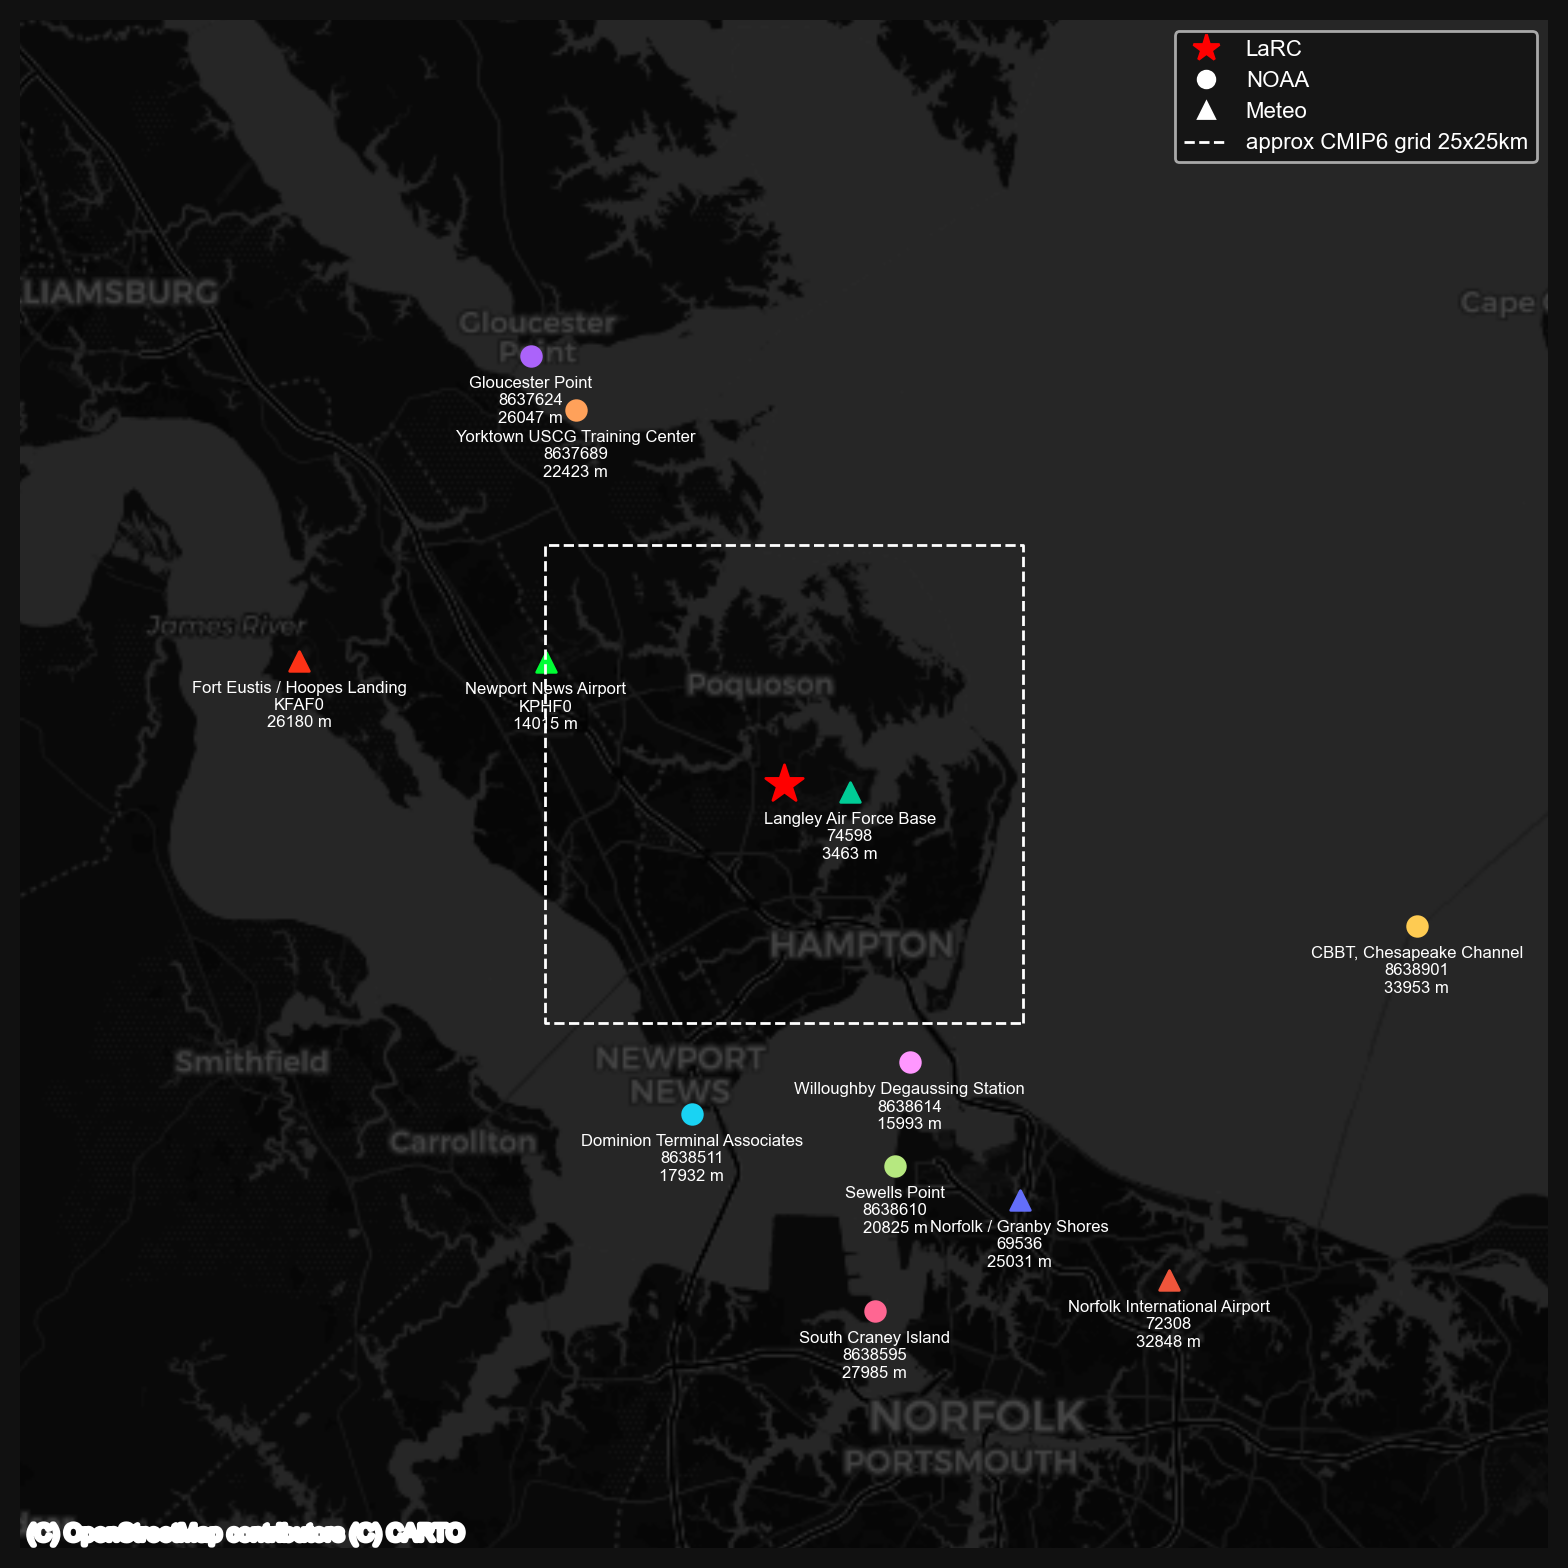

In [3]:
# Station Map
ref = gpd.GeoSeries([Point(-76.3809, 37.0862)], crs='EPSG:4326').to_crs(3857)
buffer = 12_500 # 12.5 km each direction for a 25x25 km box for cmip6
x, y = ref.geometry[0].x, ref.geometry[0].y
bbox = gpd.GeoSeries([box(x - buffer, y - buffer, x + buffer, y + buffer)], crs='EPSG:3857')

fig, ax = plt.subplots(figsize=(8, 8), dpi=200)
pad = buffer * 2.2
ax.set_xlim(x - buffer - pad, x + buffer + pad)
ax.set_ylim(y - buffer - pad, y + buffer + pad)

for dd, label, marker in [(noaa, 'NOAA', 'o'), (meteo, 'MeteoStat', '^')]:
    gdf = gpd.GeoDataFrame(dd, geometry=gpd.points_from_xy(dd.longitude, dd.latitude), crs='EPSG:4326').to_crs(3857)
    gdf = gdf.drop_duplicates(subset=['id', 'latitude', 'longitude'])
    gdf['distance'] = gdf.geometry.distance(ref[0])
    for _, r in gdf.iterrows():
        ax.scatter(r.geometry.x, r.geometry.y, s=50, color=colors[colors.id==str(r['id'])]['color'], marker=marker)
        ax.text(r.geometry.x, r.geometry.y - 3500, f'{r['name']}\n{r['id']}\n{r.distance:.0f} m', fontsize=6, ha='center')

ref.plot(ax=ax, color='red', marker='*', markersize=200, label='LaRC')
bbox.boundary.plot(ax=ax, color='white', linewidth=1, linestyle='--')
cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatter)
ax.set_axis_off()

ax.legend(handles=[
    mlines.Line2D([], [], color='red', marker='*', linestyle='None', markersize=10, label='LaRC'),
    mlines.Line2D([], [], color='white', marker='o', linestyle='None', markersize=6, label='NOAA'),
    mlines.Line2D([], [], color='white', marker='^', linestyle='None', markersize=6, label='Meteo'),
    mlines.Line2D([], [], color='white', linestyle='--', linewidth=1, label='approx CMIP6 grid 25x25km')
], fontsize=8)

plt.tight_layout()
plt.show()

## Time Interval
Might have date gaps between start and end date

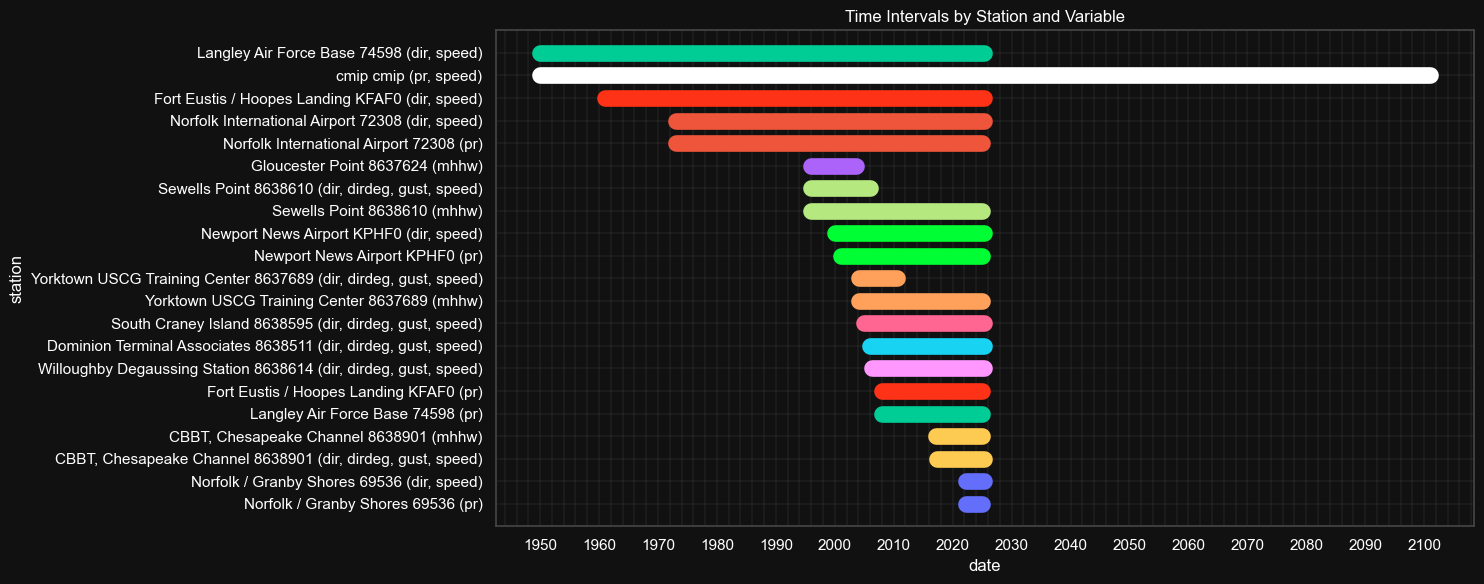

In [4]:
def get_time_intervals(df):
    res = pd.DataFrame([{'prefix': p, 'station': s, 'start_date': vals.index.min(), 'end_date': vals.index.max()}
                        for c in df.columns if not (vals := df[c].dropna()).empty for p, s in [c.split('_', 1)]])
    res[['start_date', 'end_date']] = res[['start_date', 'end_date']].apply(lambda x: x.dt.strftime('%Y-%m'))
    res = res.groupby(['station', 'start_date', 'end_date']).agg(lambda x: ', '.join(sorted(set(x)))).reset_index()
    res = res.merge(colors, left_on='station', right_on='id', how='left')

    res['station'] = res['name'] + ' ' + res['id'] + ' (' + res['prefix'] + ')'
    return res.sort_values(['start_date', 'station'])
    
def plot_time_intervals(df, title=None):
    df = df.melt(id_vars=['station', 'prefix', 'color'], value_vars=['start_date', 'end_date'],
                 var_name='type', value_name='date')
    df.date = pd.to_datetime(df.date)
    df.station = df.station.str.replace(cmip_models, 'cmip', regex=True)
    df = df.drop_duplicates(['station', 'date'])

    palette = dict(zip(df.station, df.color))
    cmip_mask = df['station'].str.contains('cmip', regex=False)
    palette.update({s: 'white' for s in df[cmip_mask]['station']})

    plt.figure(figsize=(15, 6))
    ax = sns.lineplot(data=df, x='date', y='station', hue='station', lw=12, legend=False, palette=palette)
    ax.set(title=title)
    ax.xaxis.set_minor_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_locator(mdates.YearLocator(10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', which='minor', length=0)
    ax.grid(which='both', linewidth=0.3)
    plt.tight_layout()
    plt.show()

plot_time_intervals(get_time_intervals(df), title='Time Intervals by Station and Variable')

## Correlation Matrix
#### Observed data across all stations
- High correlation (near 1) between mean higher high water (mhhw) and mean sea level (msl)
- Moderate to high correlation between wind speed and gust
- Low correlation between (mhhw, msl) and (wind speed, gust)

#### CMIP6 data across all models
- Low correlation between precipitation
- Low correlation between surface wind
- Low correlation with observed data (precip, wind speed)

#### Choose variables
- Use one of mhhw and msl $\rightarrow$ **mhhw**
- Use one of wind speed and gust $\rightarrow$ **speed**

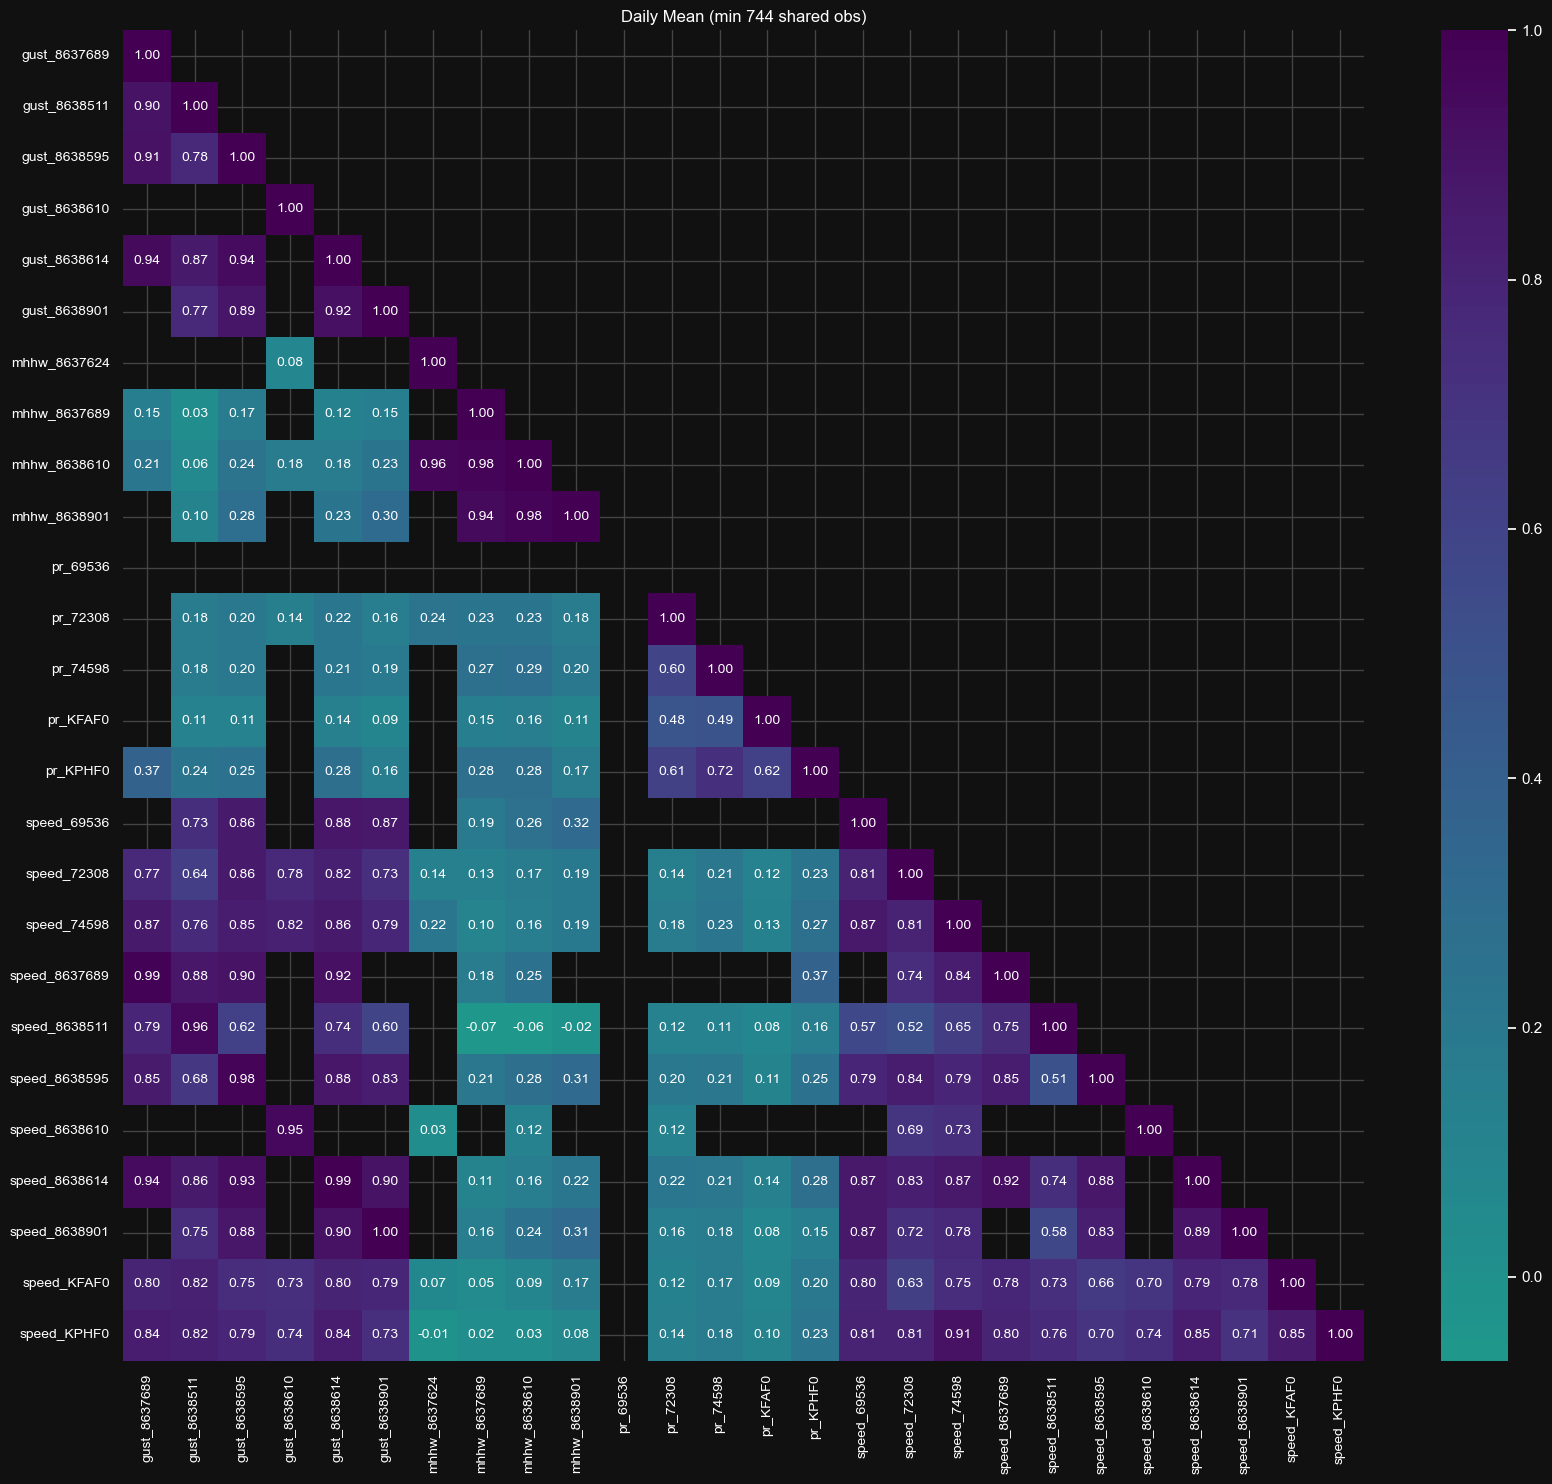

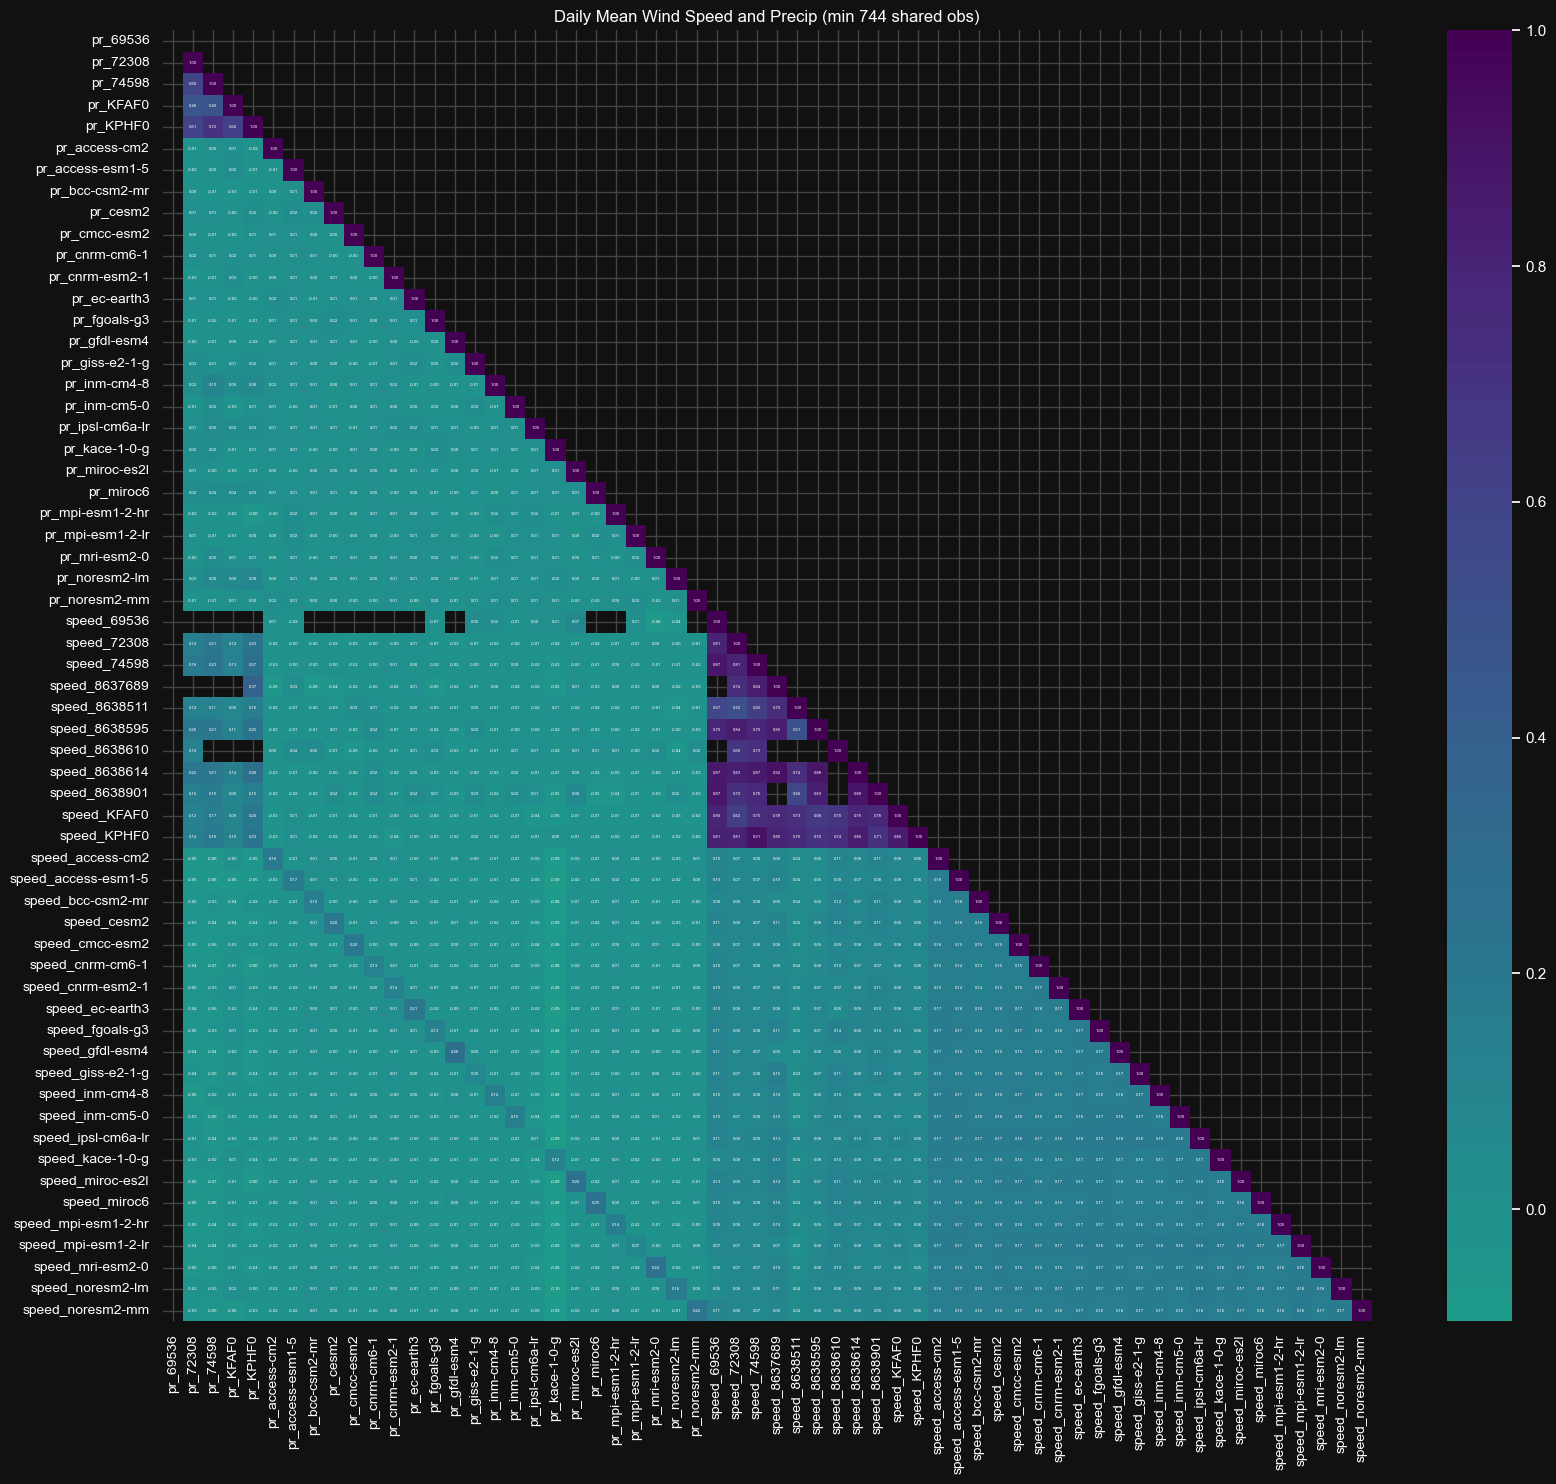

In [5]:
def plot_corr(df, title, res='h', min_shared=100, fmt='.2f', center=0, annot_size=10, label_size=10):
    resampled = df.resample(res).mean()
    non_na_counts = (~resampled.isna()).astype(int)
    shared_obs = non_na_counts.T @ non_na_counts
    insufficient_obs = shared_obs < min_shared
    corr = resampled.corr()
    corr = corr.mask(insufficient_obs)
    plt.figure(figsize=(17, 15))
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    sns.heatmap(corr, mask=mask, annot=True, fmt=fmt, cmap='viridis_r', 
                center=center, annot_kws={'size': annot_size})
    plt.title(f'{title} (min {min_shared} shared obs)')
    plt.xticks(fontsize=label_size) 
    plt.yticks(fontsize=label_size)
    plt.tight_layout()
    plt.show()

filtered = no_cmip_df.filter(regex=r'speed_|gust_|mhhw_|pr_')
plot_corr(filtered, 'Daily Mean', res='d', min_shared=31*12*2)
plot_corr(df.filter(regex=r'speed_|pr_'), 'Daily Mean Wind Speed and Precip', res='d', min_shared=31*12*2, annot_size=3)


## Monthly Means Time Series

**Wind Speed**
- Significant drops in Langley air force base and fort eustis

**Wind Gust**
- More consistent than speed

**MHHW**
- Increases overtime

In [6]:
print('STANDARD DEVIATION SUMMARY: Variability across stations vs CMIP6 models by variable group per day')
var_groups = ['speed_', 'gust_', 'mhhw_', 'pr_']
methods = {'daily': lambda df: df.resample('d').mean().std(axis=1).dropna(),
          # 'monthly_max': lambda df: df.resample('ME').max().std(axis=1).dropna(),
          # 'monthly_mean': lambda df: df.resample('ME').mean().std(axis=1).dropna(),
          # 'monthly_med': lambda df: df.resample('ME').median().std(axis=1).dropna()
          }

def get_variability(df, source_name):
   return pd.concat({f"{source_name}_{method}": pd.DataFrame({
       var: func(df.filter(regex=var)).describe() for var in var_groups
   }).T for method, func in methods.items()}, axis=0).dropna()

result = pd.concat([get_variability(no_cmip_df, "stations"), get_variability(cmip_df, "cmip6"), 
                    get_variability(df.filter(regex='speed_|pr_'), "all")])

display(result.sort_values('mean', ascending=False))

STANDARD DEVIATION SUMMARY: Variability across stations vs CMIP6 models by variable group per day


count      mean       std           min       25%  \
all_daily      pr_     55152.0  6.846943  3.732374  5.262126e-02  4.485645   
cmip6_daily    pr_     55152.0  5.948547  2.866051  3.676652e-02  4.067672   
stations_daily pr_      2850.0  4.546204  8.867315  0.000000e+00  0.677126   
all_daily      speed_  55152.0  1.494874  0.389630  5.073258e-01  1.183219   
cmip6_daily    speed_  55152.0  1.474871  0.383700  4.725949e-01  1.162887   
stations_daily speed_  22764.0  1.032611  0.585052  1.570092e-16  0.622051   
               gust_    7701.0  0.890779  0.611135  7.162361e-03  0.478859   
               mhhw_   10395.0  0.025969  0.024254  0.000000e+00  0.010607   

                            50%       75%         max  
all_daily      pr_     5.954423  8.300962  121.441130  
cmip6_daily    pr_     5.370054  7.180270   27.397052  
stations_daily pr_     2.003640  5.231236  140.435050  
all_daily      speed_  1.475882  1.772108    4.693170  
cmip6_daily    speed_  1.456510  1.752835    3.045706  
stations_daily speed_  0.958266  1.361850    4.599979  
               gust_   0.749199  1.119081    6.312814  
               mhhw_   0.021213  0.035355    1.020355

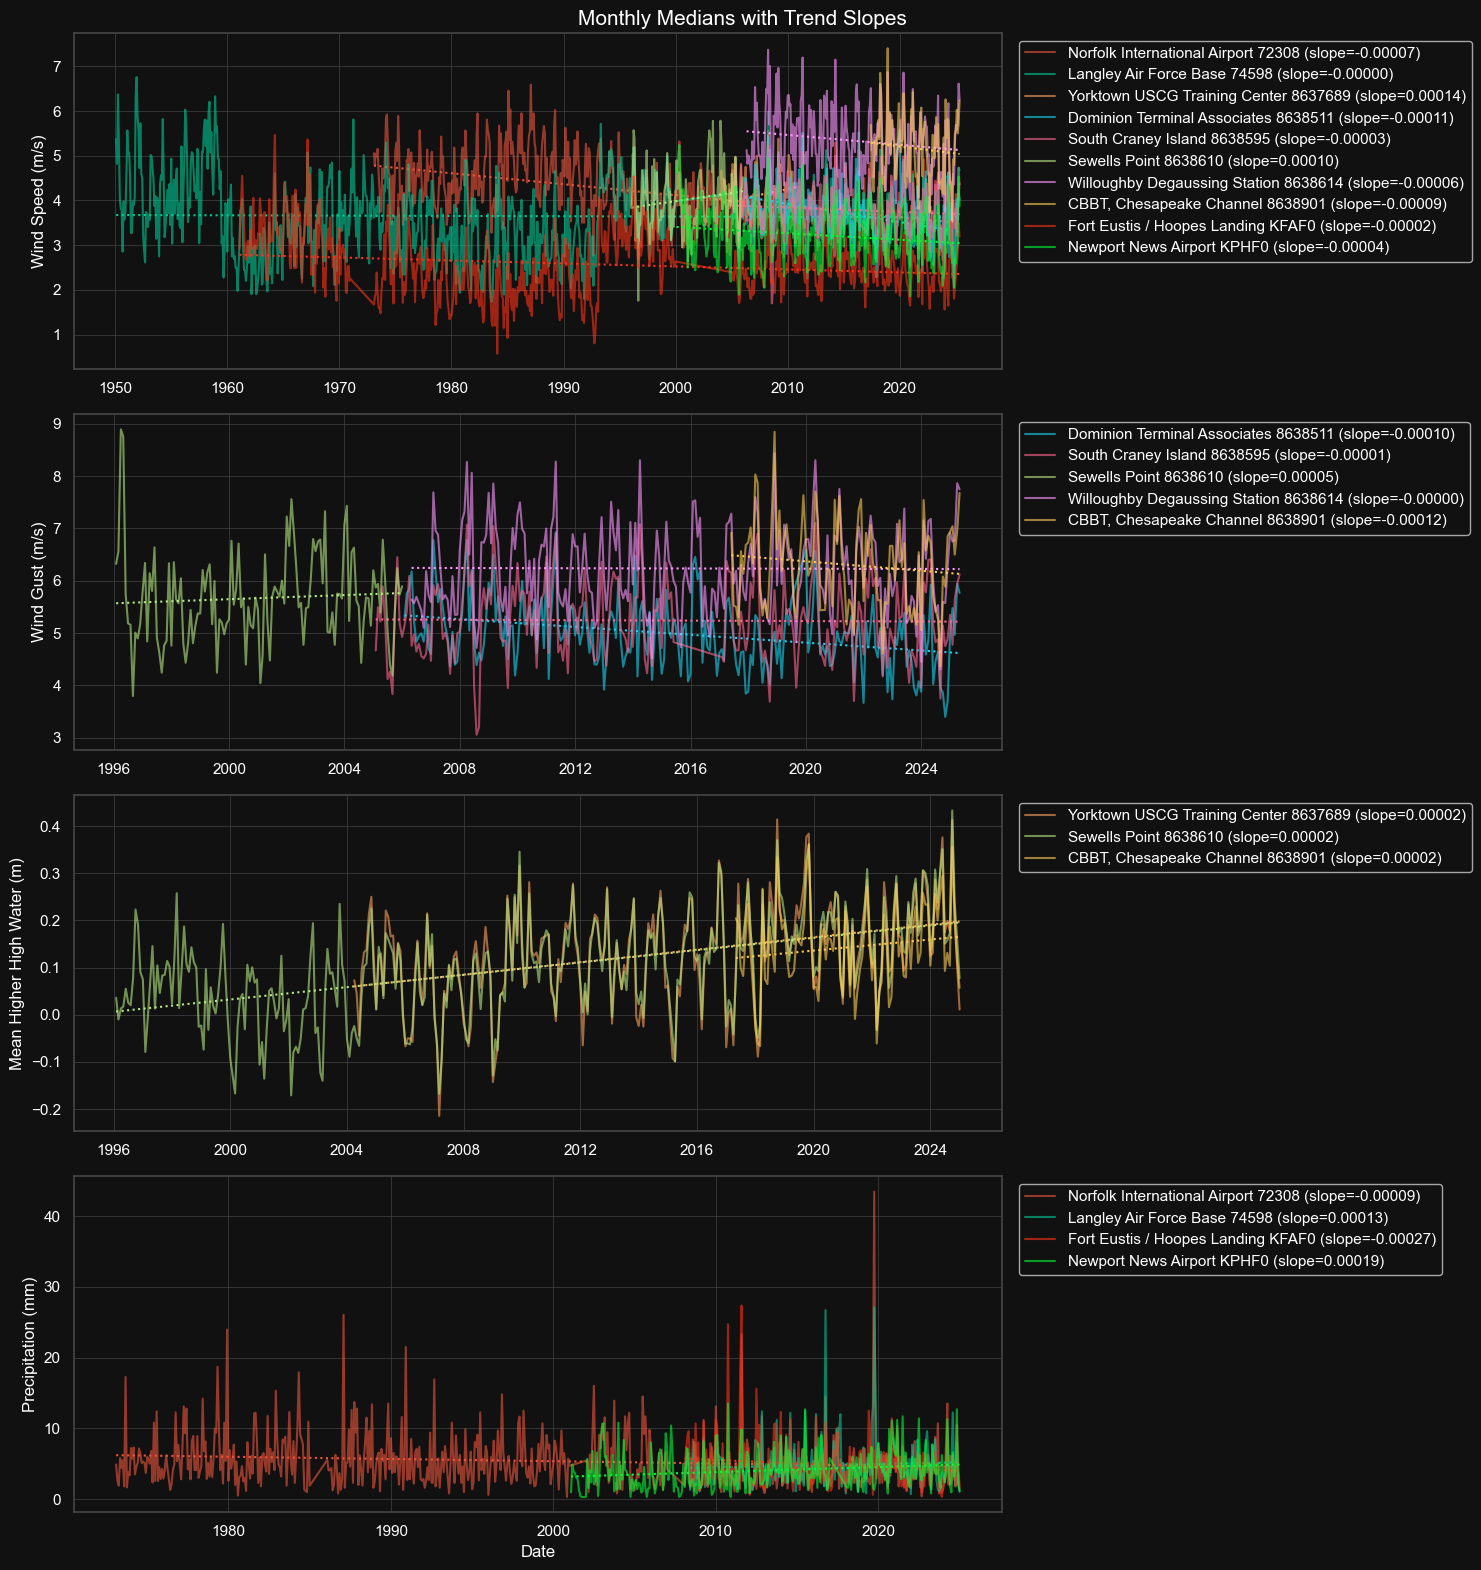

In [7]:
def plot_all_ts_subplots(df, var_list, var_map, colors):
    n_vars = len(var_list)
    fig, axes = plt.subplots(n_vars, 1, figsize=(15, 4 * n_vars))

    for i, var_regex in enumerate(var_list):
        ax = axes[i]
        monthly = df.filter(regex=var_regex).resample('ME').median().dropna(how='all')
        prefixes = [col.split('_')[0] for col in monthly.columns[1:]]
        linestyles = ['-', '--', '-.', ':']
        prefix_ls = {p: linestyles[j % len(linestyles)] for j, p in enumerate(sorted(set(prefixes)))}

        for col in monthly.columns[1:]:
            prefix, sid = col.split('_')[:2]
            row = colors[colors['id'] == sid]
            color = row.color.iloc[0]
            x = mdates.date2num(monthly.index)
            y = monthly[col].values
            mask = ~np.isnan(y)

            slope = None
            if mask.any():
                z = np.polyfit(x[mask], y[mask], 1)
                slope = z[0]
                ax.plot(mdates.num2date(x[mask]), np.poly1d(z)(x[mask]), linestyle=':', color=color)

            label = f"{row.name.iloc[0]} {sid}{f' (slope={slope:.5f})' if slope else ''}"
            label = f'{prefix} - {label}' if len(prefix_ls) > 1 else label
            sns.lineplot(x=monthly.index, y=y, ax=ax, color=color, linestyle=prefix_ls[prefix], alpha=0.6, label=label)

        ax.set_xlabel('')
        ax.set_ylabel(var_map[var_regex])
        ax.grid(True, linewidth=0.5)
        ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

    axes[-1].set_xlabel('Date')
    fig.suptitle('Monthly Medians with Trend Slopes')
    plt.tight_layout()
    plt.show()


plot_all_ts_subplots(no_cmip_df, ['speed_', 'gust_', 'mhhw_', 'pr_'], var_map, colors)

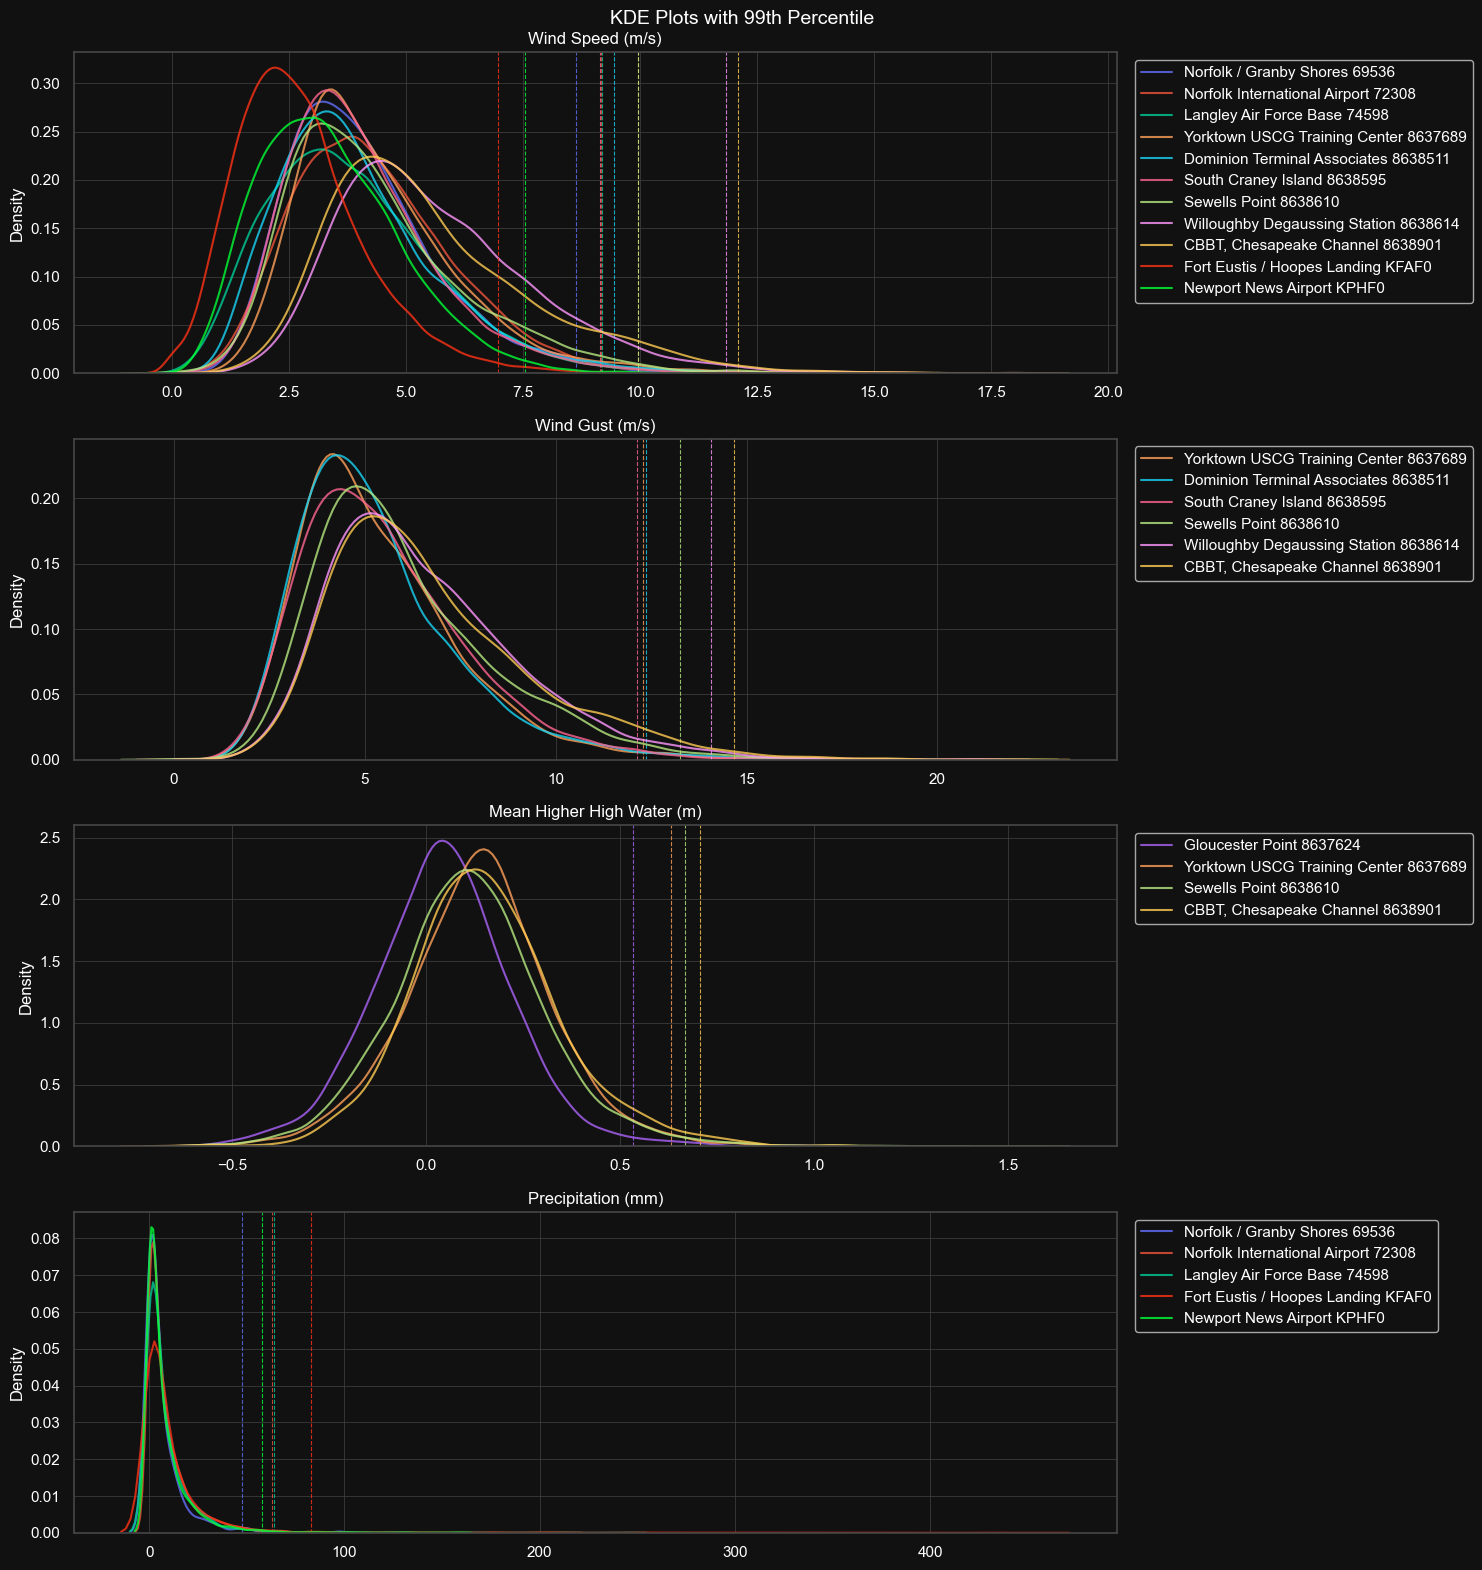

In [8]:
def plot_kde_subplots(df, var_list, var_map, colors, quantile=0.99):
    n_vars = len(var_list)
    fig, axes = plt.subplots(n_vars, 1, figsize=(15, 4 * n_vars))

    linestyles = ['-', '--', '-.', ':']

    for i, var_regex in enumerate(var_list):
        ax = axes[i]
        data = df.filter(regex=var_regex).dropna(how='all')

        prefixes = [col.split('_')[0] for col in data.columns]
        prefix_ls = {p: linestyles[j % len(linestyles)] for j, p in enumerate(sorted(set(prefixes)))}

        for col in data.columns:
            prefix, sid = col.split('_')[:2]
            row = colors[colors['id'] == sid]
            color = row.color.iloc[0]
            values = data[col].dropna()

            if not values.empty:
                sns.kdeplot(values, ax=ax, color=color, linestyle=prefix_ls[prefix], alpha=0.8,
                            label=f"{prefix} - {row.name.iloc[0]} {sid}" if len(prefix_ls) > 1 else f"{row.name.iloc[0]} {sid}")
                perc = values.quantile(quantile)
                ax.axvline(perc, color=color, linewidth=0.8, linestyle='--', alpha=0.8)

        ax.set_title(var_map[var_regex])
        ax.set_xlabel('')
        ax.set_ylabel('Density')
        ax.grid(True, linewidth=0.5)
        ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

    fig.suptitle(f'KDE Plots with {int(quantile * 100)}th Percentile', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_kde_subplots(no_cmip_df, ['speed_', 'gust_', 'mhhw_', 'pr_'], var_map, colors)

## Wind Rose Chart
- shared bins/legend
- bins only include positive values; (-0.001, x] is left exclusive
- most are southwesterly winds (wind that comes from the southwest)
- ocean is east of langley $\rightarrow$ higher coastal flood risk for east/coastal stations
    - upper part of circle from NW to SSE (0-135, 300-360)
- (more) high **southwesterly** and **(north) easterly** wind speed at willoughby and cbbt (on water)
- high gust minus speed difference at sewells, south craney, cbbt


- what wind speed/gust is considered dangerous?

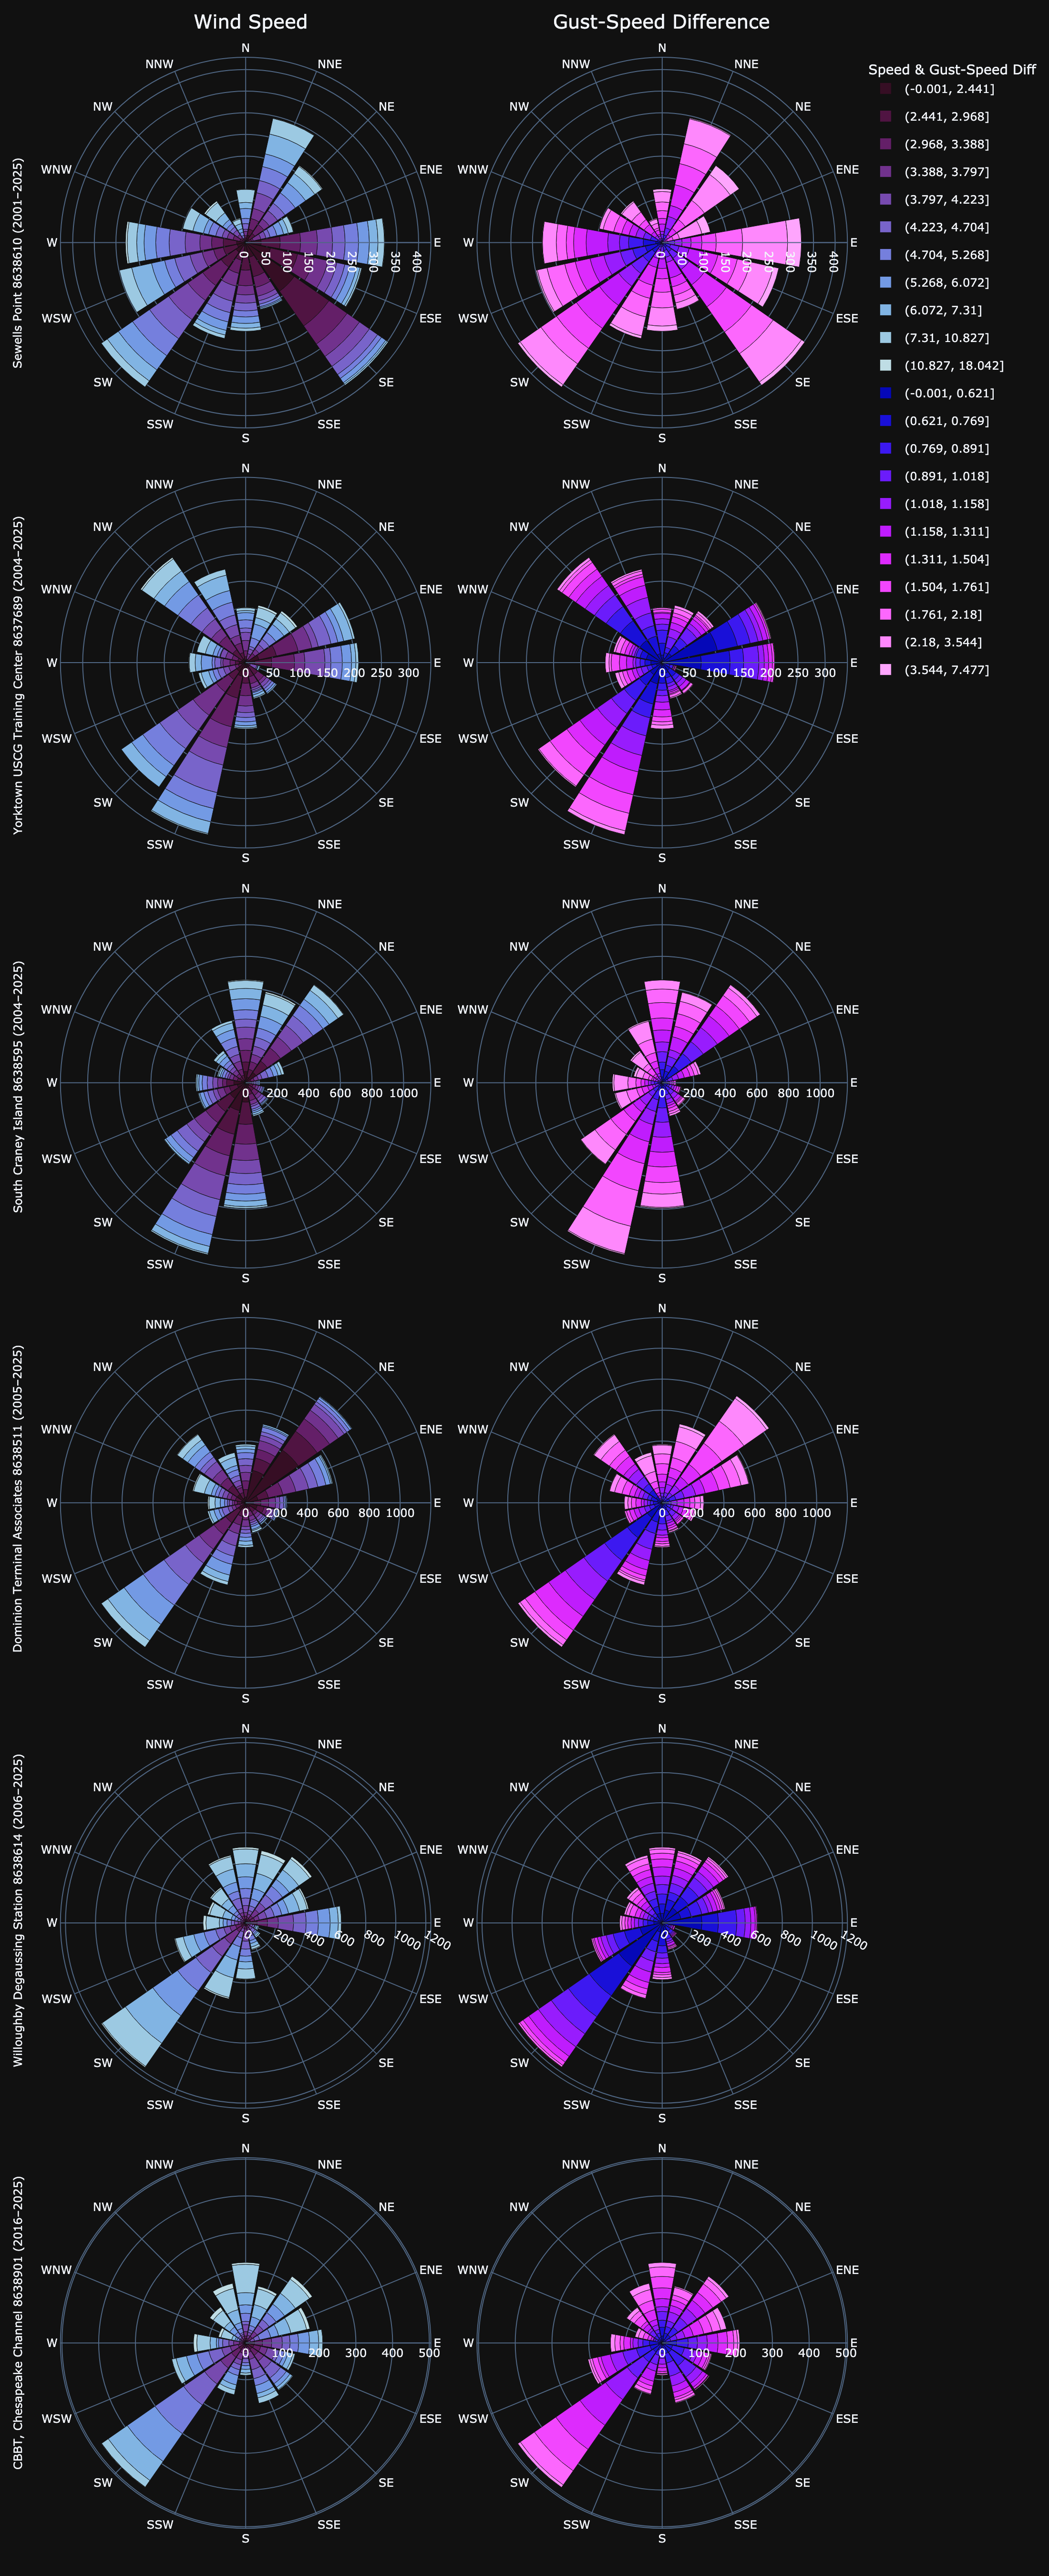

In [9]:
# Wind direction mapping
dir_map = {d: i * 22.5 for i, d in enumerate(
    ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW'])}

polar = dict(radialaxis=dict(showticklabels=True, ticks=''),
    angularaxis=dict(showticklabels=True, tickmode='array', tickvals=list(dir_map.values()), 
                     ticktext=list(dir_map.keys()), direction='clockwise', rotation=90))

configs = [('speed', 'Wind Speed', px.colors.sequential.dense_r),
           ('diff', 'Wind Gust-Speed Difference', px.colors.sequential.Plotly3)]

# Generate bins for global data
quantiles = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, .99, 1]
ss, gg = wind_df.filter(regex='speed_'), wind_df.filter(regex='gust_')
ss.columns, gg.columns = range(ss.shape[1]), range(gg.shape[1])
bins = {v: df.stack().quantile(quantiles).values for df, v in zip([ss, gg - ss], ['speed', 'diff'])}

n = len(wind_stations)
fig = make_subplots(rows=n, cols=2, subplot_titles=[], vertical_spacing=0.02, horizontal_spacing=0.05,
                    specs=[[{'type': 'polar'}, {'type': 'polar'}]] * n,)

for idx, id in enumerate(wind_stations):
    row = idx + 1
    info = noaa[noaa.id == str(id)].iloc[0]
    dd = wind_df.filter(regex=str(id)).dropna()
    dd.columns = [c.split('_')[0] for c in dd.columns]
    dd['diff'] = dd['gust'] - dd['speed']
    dd['angle'] = dd['dir'].map(dir_map)

    for v in ['speed', 'diff']:
        dd[f'{v}_bin'] = pd.cut(dd[v], bins[v], include_lowest=True)

    title = f'{info['name']} {id} ({info.start_date.year}–{info.end_date.year})'
    fig.add_annotation(text=title, x=-0.05, y=1 - ((row - 0.5) * (1/n)), showarrow=False, textangle=-90,
                       font=dict(size=12), align='center', xanchor='center', yanchor='middle')
    if row == 1:
        fig.add_annotation(text='Wind Speed', x=0.17, y=1.02, showarrow=False, font=dict(size=20))
        fig.add_annotation(text='Gust-Speed Difference', x=0.90, y=1.02, showarrow=False, font=dict(size=20))
    for i, (v, l, c) in enumerate(configs, start=1):
        grouped = dd.groupby(['angle', f'{v}_bin']).size().reset_index(name='frequency')
        for j, b in enumerate(grouped[f'{v}_bin'].unique()):
            subset = grouped[grouped[f'{v}_bin'] == b]
            fig.add_trace(go.Barpolar(r=subset['frequency'], theta=subset['angle'], name=str(b),
                legendgroup=f'{v}_group_{b}', marker_color=c[j % len(c)], showlegend=(row==1)), row=row, col=i)

fig.update_layout(template='plotly_dark', width=1100, height=2700, title_x=0.5, 
    showlegend=True,legend_title=dict(text="Speed & Gust-Speed Diff"), margin=dict(l=60, r=10, t=60, b=50),
    **{f'polar{i}': polar for i in range(1, 2 * n + 1)})

display(Image(pio.to_image(fig, format='png', width=1100, height=2700, scale=2))) if static else fig.show()

## Daily Tides: Box Plot and Time Series (IGNORE, DOES NOT MAKE SENSE)
- only significant tides (LL, L, H, HH) were labeled in the noaa dataset (6 minute intervals)
- tide types are aggregated using the max mode of each day across stations
- still need to check if thresholds change overtime for HH (and H) because boxplot comparison is similar
- in most cases, HH contains higher extremes for mhhw, pr, and speed
- L tide boxes are the most to the right
### TODO
- get the hh value for each day per station
- can't group categories with current way

In [10]:
# tide_type = (df.filter(regex='type_').dropna(how='all').apply(lambda r: r.dropna().mode().max(), axis=1)
#              .replace(tide_map))
# filtered = df.loc[tide_type.index].filter(regex='speed_|mhhw_|pr_')

# prefixes = sorted({col.split('_')[0] for col in filtered})
# suffixes = sorted({col.split('_')[-1] for col in filtered})
# color_map = {suf: px.colors.qualitative.Plotly[i % 10] for i, suf in enumerate(suffixes)}
# all_groups = [f'{suf}_{t}' for suf in suffixes for t in list(tide_map.values())][::-1]

# fig = make_subplots(rows=1, cols=len(prefixes), shared_yaxes=True,
#                     subplot_titles=prefixes, horizontal_spacing=0.02)

# for i, pre in enumerate(prefixes):
#     for col in filter(lambda c: c.startswith(pre + '_'), filtered):
#         suf = col[len(pre)+1:]
#         sub = filtered[[col]].assign(tide_type=tide_type, station_tide=lambda d: d['tide_type'].radd(f'{suf}_'))
#         row = colors[colors['id'] == suf]
#         color = row.color.iloc[0]
#         for group in all_groups:
#             if not (gdata := sub[sub['station_tide'] == group]).empty:
#                 fig.add_trace(go.Box(x=gdata[col], y=[group] * len(gdata), boxpoints='outliers', 
#                                      marker=dict(size=5, color=color), line=dict(width=1, color=color),
#                                      showlegend=False, orientation='h'), row=1, col=i+1)            

# fig.update_layout(template='plotly_dark', height=5*len(tide_type.unique())*len(all_groups), width=200*len(prefixes),
#     title={'text': 'Comparison by Tides', 'x':0.5,'xanchor': 'center'}, margin=dict(l=60, r=10, t=50, b=50),)
# for i, pre in enumerate(prefixes):
#     fig.update_xaxes(title_text=pre, row=1, col=i+1)
# fig.update_yaxes(title_text='Stations and CMIP6 Models (Tide Type)', row=1, col=1)
# used_groups = sorted(
#     {f"{suf}_{t}" for suf in suffixes for t in ordered_tides if any(filtered.columns.str.endswith(f"_{suf}"))},
#     key=lambda x: (suffixes.index(x.split('_')[0]), ordered_tides[::-1].index(x.split('_')[1])),
#     reverse=False
# )

# for i in range(1, len(prefixes)+1):
#     fig.update_yaxes(categoryorder='array', categoryarray=used_groups, row=1, col=i)


# display(tide_type.value_counts())
# display(Image(pio.to_image(fig, format='png', height=5*len(tide_type.unique())*len(all_groups), 
#                             width=500*len(prefixes), scale=2)))  if static else fig.show()

In [11]:
# def plot_variable_by_tide_type(df, var, tide_map, ordered_tides):
    
#     filtered = df.filter(regex=fr'{var}|type_').dropna(how='all')
#     suffixes = sorted({col.split('_')[-1] for col in filtered})

#     fig, axes = plt.subplots(len(suffixes), 1, figsize=(16, 4 * len(suffixes)), sharex=True, sharey=True)
#     if len(suffixes) == 1:
#         axes = [axes]

#     for i, suf in enumerate(suffixes):
#         val_col = f'{var}{suf}'
#         type_col = f'type_{suf}'
#         if val_col in df.columns and type_col in df.columns:
#             subdf = df[[val_col, type_col]].dropna().rename(columns={val_col: 'value', type_col: 'type'})
#             subdf['tide_type'] = pd.Categorical(
#                 subdf['type'].replace(tide_map), categories=ordered_tides, ordered=True)

#             ax = axes[i]
#             sns.lineplot(data=subdf, x=subdf.index, y='value', hue='tide_type',
#                          linewidth=0.8, alpha=0.8, ax=ax)

#             for tide in ordered_tides:
#                 group = subdf[subdf['tide_type'] == tide]
#                 if not group.empty:
#                     x, y = mdates.date2num(group.index), group['value'].values
#                     mask = ~np.isnan(y)
#                     if mask.any():
#                         ax.plot(group.index[mask], np.poly1d(np.polyfit(x[mask], y[mask], 1))(x[mask]), linestyle=':',
#                                 color=ax.get_lines()[ordered_tides.index(tide)].get_color())

#             ax.set_title(f'Station {suf}', loc='left', fontsize=12)
#             ax.grid(True, linewidth=0.5)
#             ax.set_ylabel('')
#             ax.get_legend().remove()

#     axes[-1].set_xlabel('Date')
#     fig.text(0.05, 0.5, var_map[var], va='center', rotation='vertical', fontsize=14)
#     fig.suptitle(f"Daily {var_map[var]} by Tide Types", fontsize=16, y=1.02)

#     handles, labels = axes[0].get_legend_handles_labels()
#     fig.legend(handles, labels, title='Tide Type', loc='upper center',
#                bbox_to_anchor=(0.5, 1), ncol=4)

#     plt.tight_layout(rect=[0.06, 0, 0.95, 0.98])
#     plt.show()
    
# plot_variable_by_tide_type(no_cmip_df, 'mhhw_', tide_map, ordered_tides)

# Anomoly Detection
- STL (Season-Trend decomposition using LOESS) to decompose time series and analyze residuals
- https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.STL.html
- Detect positive extremes in time series
    - Identify sominant cyclical patterns using periodogram analysis
    - Decompose time series using STL to separate trend, seasonal patterns, and residuals
    - Isolate positive deviations from expected values (trend + seasonal)
    - Use median and median absolute deviation to identify anomalies that exceed a specified threshold

In [12]:
# %%time

# def estimate_dominant_period(series, min_period=14, max_period=730):
#     """Estimates dominant period using periodogram analysis."""
#     if len(series) < min_period*2:
#         return None
#     freqs, psd = periodogram(series.dropna(), scaling='density', window='hamming')
#     freqs, psd = freqs[1:], psd[1:]
#     mask = (1/freqs >= min_period) & (1/freqs <= max_period)
#     return int(round(1 / freqs[mask][np.argmax(psd[mask])])) if mask.any() else None
    
# def detect_positive_extremes(df, z_thresh=3, min_period=14, max_period=730, min_strength=0.05):
#     """Detects only positive extremes using STL decomposition and z-scores."""
#     out = pd.DataFrame(False, index=df.index, columns=df.columns)
#     log = pd.DataFrame(index=df.columns, columns=['status', 'period', 'strength', 'anomaly_count', 'reason'])
    
#     for col in df:
#         s = df[col].dropna()
#         if len(s) < min_period*2:
#             log.loc[col, ['status', 'reason']] = ['skipped', 'insufficient data']
#             continue
            
#         period = estimate_dominant_period(s, min_period, max_period)
#         if period is None:
#             log.loc[col, ['status', 'reason']] = ['skipped', 'no period found']
#             continue
        
#         try:
#             stl = STL(s, period=period, robust=True).fit()
#             strength = 1 - (np.var(stl.resid) / np.var(s - stl.trend))
#             log.loc[col, ['period', 'strength']] = [period, strength]
            
#             if strength < min_strength or strength < 0:
#                 log.loc[col, ['status', 'reason']] = ['skipped', f'weak/invalid seasonality']
#                 continue
            
#             pos = (s - stl.trend - stl.seasonal).where(lambda x: x > 0)
#             # median and median absolute deviation (mad)
#             # 1.4826 scaling factor to make mad consistent with std for normally distributed data
#             med, mad = np.nanmedian(pos), 1.4826 * np.nanmedian(np.abs(pos - np.nanmedian(pos)))

#             if np.isnan(mad) or mad == 0:
#                 out.loc[pos.index, col] = pos > 0
#             else:
#                 mod_z = 0.6745 * (pos - med) / mad # 0.6745 is reciprocal of 1.4826 factor
#                 out.loc[pos.index, col] = mod_z > z_thresh

#             log.loc[col, ['status', 'anomaly_count']] = ['success', out[col].sum()]

#         except Exception as e:
#             log.loc[col, ['status', 'reason']] = ['error', str(e)]

#     return out, log.apply(pd.to_numeric, errors='ignore')

# anomalies, log = detect_positive_extremes(no_cmip_df.filter(regex='speed_|mhhw_|pr_'))
# display(log)

In [13]:
# col = 'mhhw_8638610'
# dd = df[col].dropna()
# dd.plot(figsize=(14, 4), label='Observed')
# dd[anomalies[col].loc[dd.index]].plot(style='ro', label='Anomaly')
# plt.legend()
# plt.title(f"Anomalies in {col}")
# plt.ylabel(col)
# plt.grid(True, linewidth=0.5)
# plt.tight_layout()
# plt.show()

In [14]:
# dd[anomalies[col].loc[dd.index]]